# BarelangFC Vision Algorithm

## Image Variable 

* **rgbImage** : raw image data dari kamera yang sudah di resize
* **modRgbImage** : RGB image hasil deteksi
* **hsvImage** : hasil konversi dari rgbImage
* **gBinary** : binary image dari warna hijau (lapangan)
* **gBinaryInvert** : binary image hasil dari invert gBinary
* **gBinaryInvertErode** : hasil morfologi erode dari gBinaryInvert
* **gBinaryInvertDilate** : hasil morfologi erode dari gBinaryInvertErode
* **wBinary** : binary image dari warna putih

## Thresholding Variable

### Thresholding warna hijau

* **gHMin** : Hue minimum untuk filter warna hijau
* **gSMin** : Saturation minimum untuk filter warna hijau
* **gVMin** : Value minimum untuk filter warna hijau
* **gHMax** : Hue maximum untuk filter warna hijau
* **gSMax** : Saturation maximum untuk filter warna hijau
* **gVMax** : Value maximum untuk filter warna hijau

### Thresholding warna putih

* **wHMin** : Hue minimum untuk filter warna putih
* **wSMin** : Saturation minimum untuk filter warna putih
* **wVMin** : Value minimum untuk filter warna putih
* **wHMax** : Hue maximum untuk filter warna putih
* **wSMax** : Saturation maximum untuk filter warna putih
* **wVMax** : Value maximum untuk filter warna putih

## Import All Dependencies

In [1]:
import time
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as wg
from IPython.display import display

In [2]:
# Definisi umum
IMAGE_WIDTH = 640
HALF_IMAGE_WIDTH = IMAGE_WIDTH / 2
IMAGE_HEIGHT = 360

## Change From Coordinat Scan to Coordinat Camera

In [3]:
# Transform scanning coordinat to camera coordinat
def transToImgFrame(x,y):
    # x = x + 160
    x = x + HALF_IMAGE_WIDTH
    y = (y-IMAGE_HEIGHT) * -1
    return (x,y)

## Polar to Cartesian 

In [4]:
# Polar to cartesian 
def polToCart(radius, theta):
    x = int(radius * math.cos(math.radians(theta)))
    y = int(radius * math.sin(math.radians(theta)))
    return (x,y)

In [5]:
def distancePointToPoint(p0, p1):
    return math.sqrt(((p1[0]-p0[0])*(p1[0]-p0[0])) + ((p1[1]-p0[1])*(p1[1]-p0[1])))

## Load Image From File

In [6]:
matplotlib.rcParams['figure.figsize'] = (15,15)

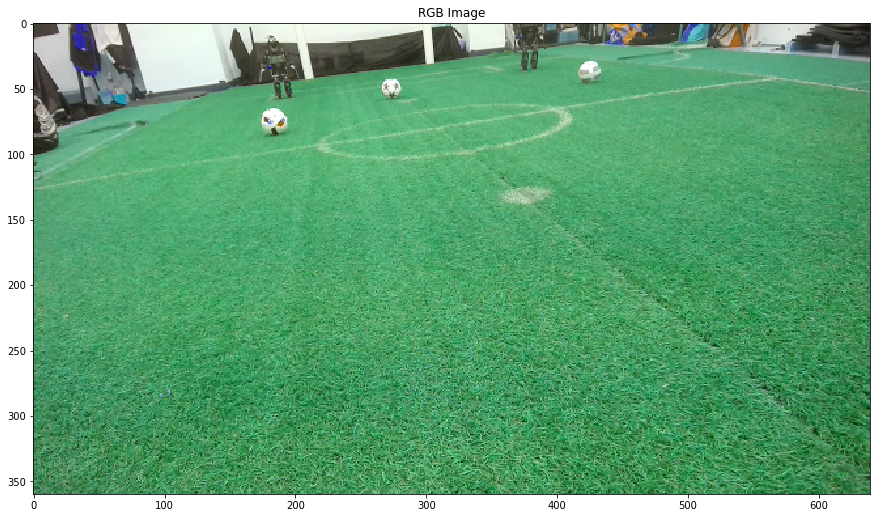

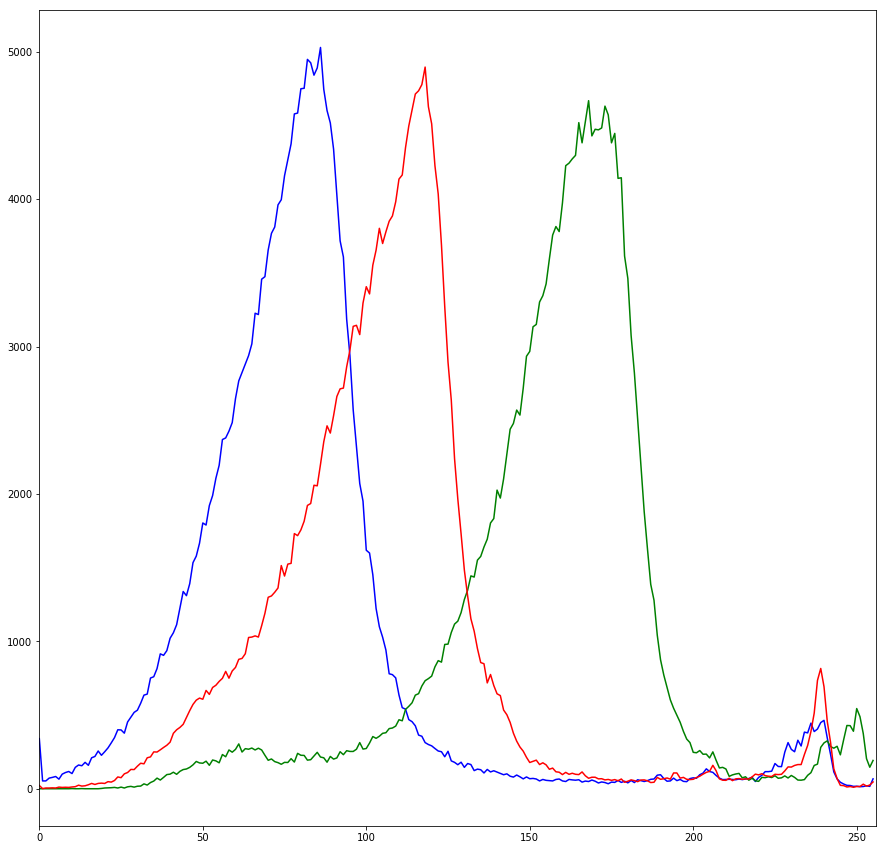

In [21]:
rgbImage = cv2.imread('images\image3.jpg')
rgbImage = cv2.resize(rgbImage,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
modRgbImage = rgbImage.copy()

plt.imshow(rgbImage)
plt.title('RGB Image')
plt.show()

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([rgbImage],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

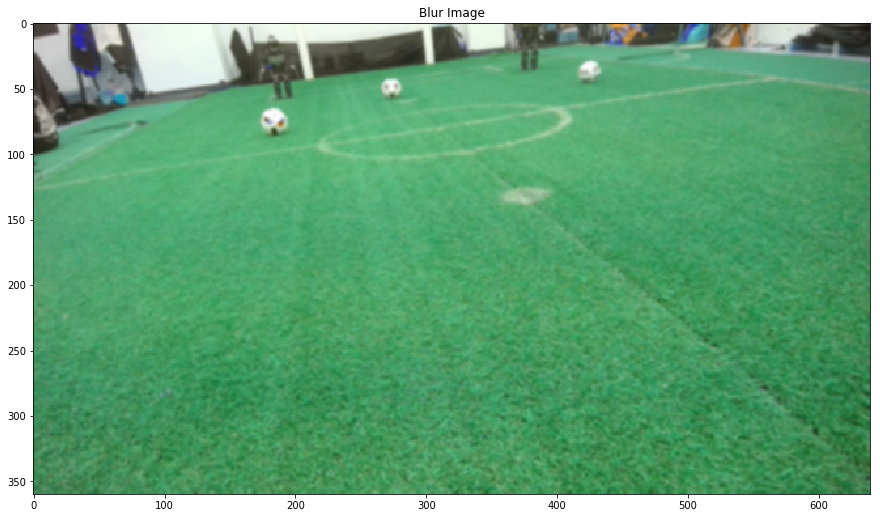

In [8]:
blurImage = cv2.GaussianBlur(rgbImage,(5,5),0)
plt.imshow(blurImage)
plt.title('Blur Image')
plt.show()

## Convert RGB Image to HSV Image

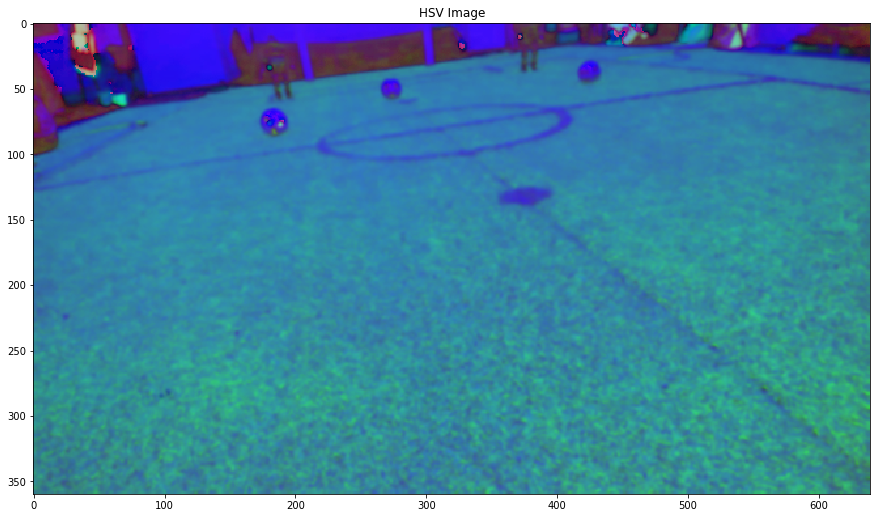

In [9]:
hsvImage = cv2.cvtColor(blurImage, cv2.COLOR_BGR2HSV)

plt.imshow(hsvImage)
plt.title('HSV Image')
plt.show()

## Field Contour Detection

In [10]:
# Setting HSV Green
gHMin = wg.IntSlider(value=40,  min=0, max= 255, description='Gr H Min : ')
gSMin = wg.IntSlider(value=50,  min=0, max= 255, description='Gr S Min : ')
gVMin = wg.IntSlider(value=55,  min=0, max= 255, description='Gr V Min : ')

gHMax = wg.IntSlider(value=60,  min=0, max= 255, description='Gr H Max : ')
gSMax = wg.IntSlider(value=255, min=0, max= 255, description='Gr S Max : ')
gVMax = wg.IntSlider(value=255, min=0, max= 255, description='Gr V Max : ')

display(gHMin, gSMin, gVMin, gHMax, gSMax, gVMax)

IntSlider(value=40, description=u'Gr H Min : ', max=255)

IntSlider(value=50, description=u'Gr S Min : ', max=255)

IntSlider(value=55, description=u'Gr V Min : ', max=255)

IntSlider(value=60, description=u'Gr H Max : ', max=255)

IntSlider(value=255, description=u'Gr S Max : ', max=255)

IntSlider(value=255, description=u'Gr V Max : ', max=255)

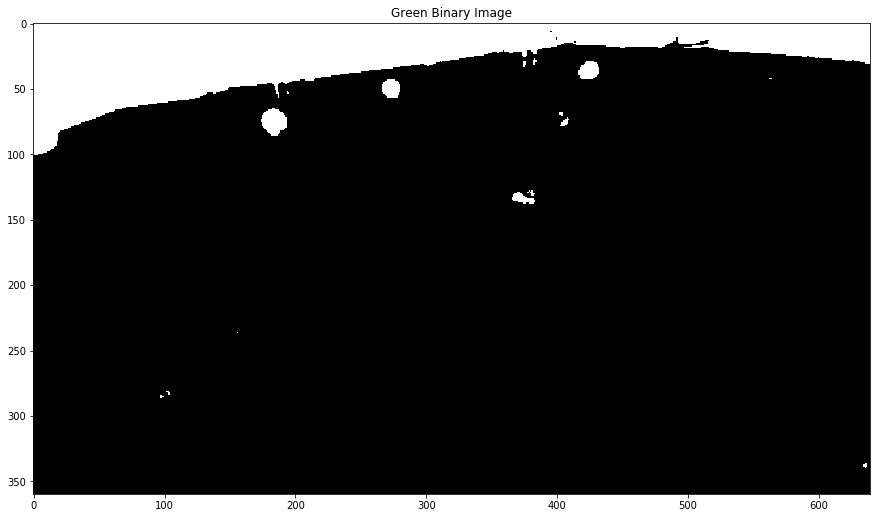

In [11]:
lowerGreen = np.array([gHMin.value,gSMin.value,gVMin.value])
upperGreen = np.array([gHMax.value,gSMax.value,gVMax.value])
gBinary = cv2.inRange(hsvImage, lowerGreen, upperGreen)
plt.imshow(gBinary, cmap='Greys')
plt.title('Green Binary Image')
plt.show()

### Fungsi fieldContourExtraction

#### Input :

* inputImage : berupa image rgb yang akan dideteksi 
* inputBinaryImage : berupa binary image yang dijadikan referensi untuk di scanning
* angleStep : step per derajat
* lengthStep : step per jarak
* enableDebug : untuk menampilkan hasil deteksi, sebaiknya di-disable agar prosesnya cepat

#### Ouput :
* npPoint : berupa array dari beberapa titik yang berhasil dideteksi

In [12]:
# fungsi rotate scan, input berupa hsv output berupa rgb yang hanya gambar lapangan saja
# enableDebug digunakan untuk menampilkan gambar hasil proses
def fieldContourExtraction(inputImage, inputBinaryImage, angleStep, lengthStep, noiseThreshold, enableDebug):
#     grayImage = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH], dtype=np.uint8)
    npPoint = np.zeros((1,2), dtype=int)
    outputImage = inputImage.copy()
    maxLength = int(math.sqrt(HALF_IMAGE_WIDTH*HALF_IMAGE_WIDTH+IMAGE_HEIGHT*IMAGE_HEIGHT))
    totalPoint = 0
    lastLength = 0
    angle = 180
    while angle >= 0:
        foundGreen = False
        lastFoundGreen = False
#         print 'Angle = {}'.format(angle)
        length = maxLength
        while length >= 0:
            x,y =  polToCart(length,angle)
            x,y =  transToImgFrame(x,y)
            if x >= 0 and x < IMAGE_WIDTH and y >= 0 and y < IMAGE_HEIGHT:          
                if foundGreen == False:
                    warna = inputBinaryImage.item(y,x) 
            else:
                warna = 0

            # Jika belum ketemu hijau
            if foundGreen == False:
                # Ketemu warna hijau
                if warna == 255:
                    # Cek noise 
                    # Ukur jarak antara titik yang sebelumnya dengan titik sekarang
#                     print npPoint
                    arrayLength, _ = npPoint.shape
#                     print 'pa {}'.format(panjangarr)
                    if arrayLength >= 2:
                        deltaLength = distancePointToPoint(npPoint[-2,:2], [x,y])
#                         deltaLength = length-lastLength
                    else:
                        deltaLength = 0
#                     print 'Delta {}'.format(deltaLength)
                    if angle == 179:
                        foundGreen = True
                    else:
                        if deltaLength < noiseThreshold:
                            foundGreen = True
                    # Update gambar dan np point
                    if foundGreen == True:
                        npPoint = np.insert(npPoint, totalPoint, [x,y],axis=0)
                        if enableDebug == True:
                            color = (0,0,255)
                            cv2.circle(outputImage,(x,y), 2, color, -1)
                        totalPoint += 1
                        foundGreen == True  
                        lastLength = length
            else:
                break
            lastFoundGreen = foundGreen
            length = length - lengthStep
        angle = angle - angleStep
    # Delete point yang terakhir
    # tambahkan point 0 dan point akhir
    npPoint = np.insert(npPoint, 0, [0,IMAGE_HEIGHT-1],axis=0)
    npPoint = np.insert(npPoint, -1, [IMAGE_WIDTH-1,IMAGE_HEIGHT-1],axis=0)
    npPoint = np.delete(npPoint, -1, axis=0)
    if enableDebug == True:
        plt.imshow(outputImage)
        plt.title('Output Image')
        plt.show()
    return npPoint

#### Test the algorithm

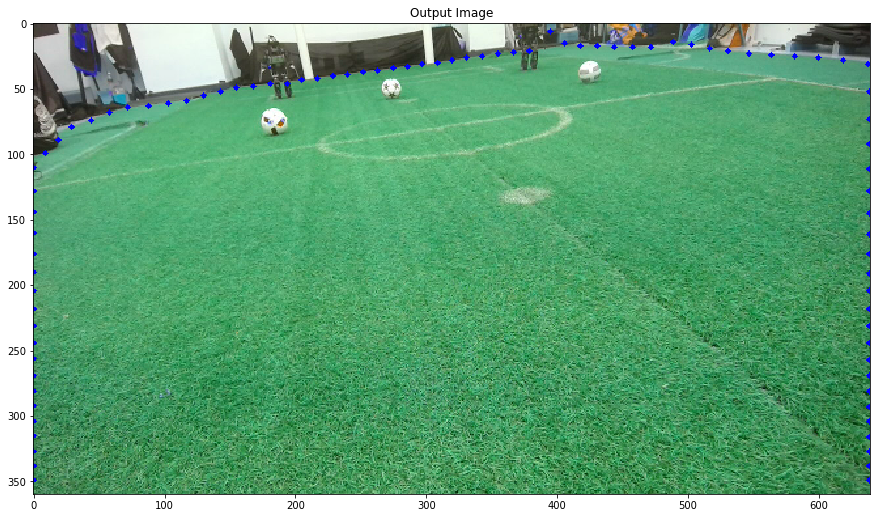

[[  0 359]
 [  0 349]
 [  0 338]
 [  0 327]
 [  0 315]
 [  0 304]
 [  0 292]
 [  0 281]
 [  0 269]
 [  0 256]
 [  0 244]
 [  0 231]
 [  0 218]
 [  0 204]
 [  0 190]
 [  0 176]
 [  0 160]
 [  0 144]
 [  0 128]
 [  0 110]
 [  9  99]
 [ 19  89]
 [ 29  79]
 [ 44  74]
 [ 58  68]
 [ 72  64]
 [ 88  63]
 [103  61]
 [117  59]
 [130  55]
 [143  52]
 [155  49]
 [168  48]
 [181  46]
 [194  46]
 [205  43]
 [217  42]
 [229  40]
 [240  39]
 [252  37]
 [263  36]
 [275  34]
 [286  33]
 [297  31]
 [309  30]
 [320  28]
 [331  26]
 [343  25]
 [355  23]
 [367  22]
 [379  21]
 [395   6]
 [406  15]
 [418  17]
 [431  17]
 [444  18]
 [458  18]
 [472  18]
 [489  14]
 [503  16]
 [517  19]
 [531  21]
 [547  23]
 [564  24]
 [582  25]
 [600  26]
 [619  28]
 [638  31]
 [639  52]
 [639  73]
 [639  92]
 [639 111]
 [639 128]
 [639 145]
 [639 161]
 [639 176]
 [639 191]
 [639 204]
 [639 218]
 [639 231]
 [639 244]
 [639 257]
 [639 269]
 [639 281]
 [639 293]
 [639 304]
 [639 316]
 [639 327]
 [639 338]
 [639 349]
 [639 359]

In [13]:
pointOfContour = fieldContourExtraction(rgbImage,gBinary,2,1,40,True)
print pointOfContour

Generate contour dari point yang terdeteksi

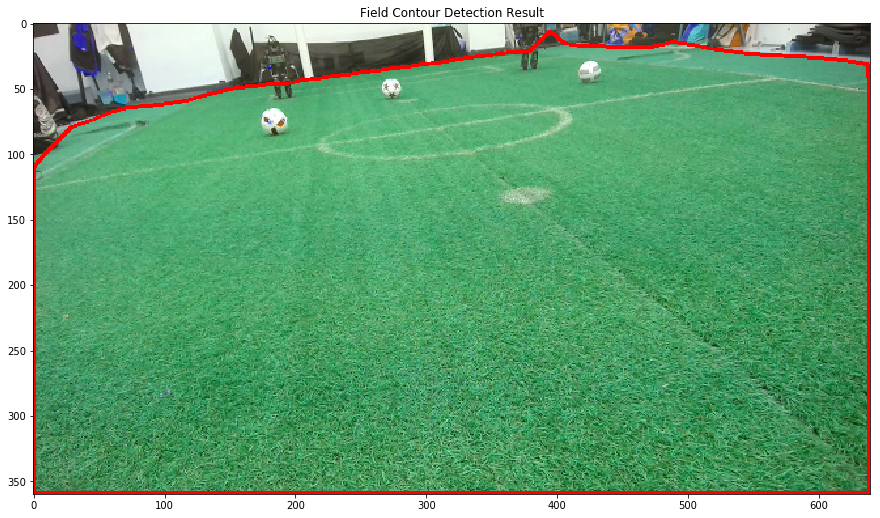

In [14]:
fieldContour = np.array(pointOfContour).reshape((-1,1,2)).astype(np.int32)
cv2.drawContours(modRgbImage,[fieldContour],0,(255,0,0),2)
plt.imshow(modRgbImage)
plt.title('Field Contour Detection Result')
plt.show()

## Ball Detection 
### Mode 1 

#### Invert From Field

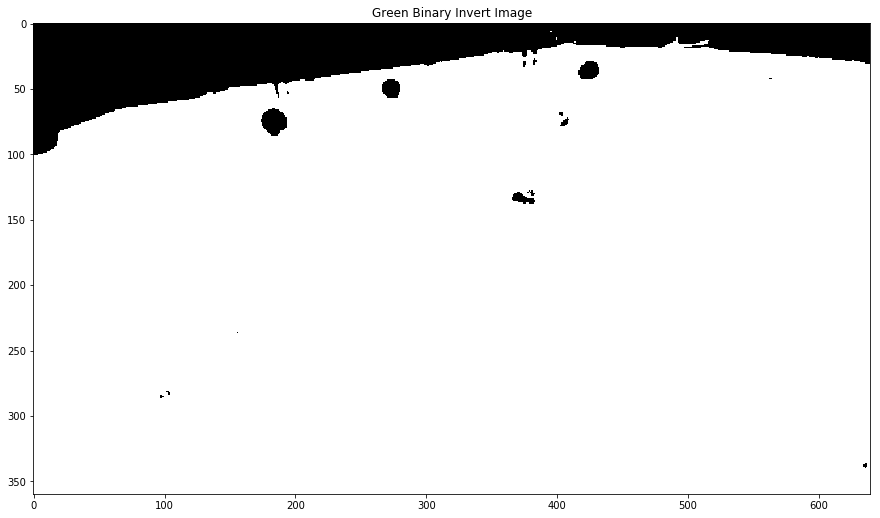

In [15]:
gBinaryInvert = cv2.bitwise_not(gBinary)
plt.imshow(gBinaryInvert, cmap='Greys')
plt.title('Green Binary Invert Image')
plt.show()

#### Morphology

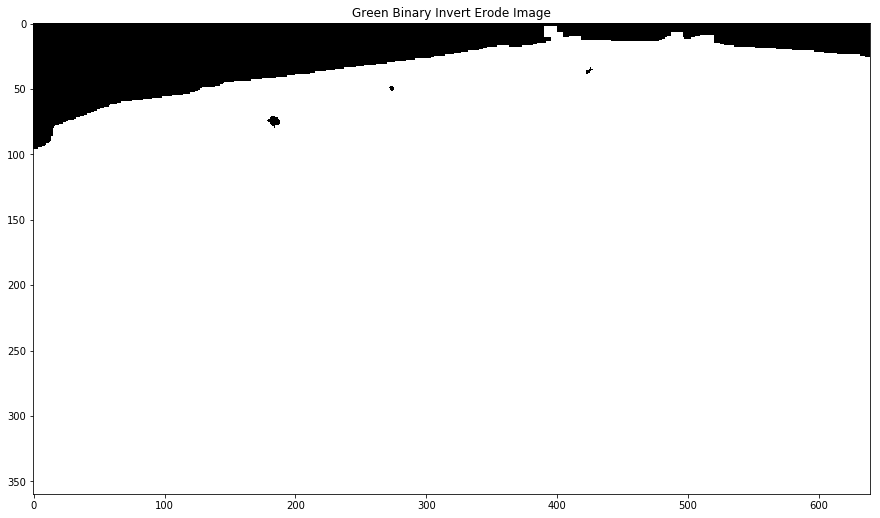

In [16]:
kernel = np.ones((5,5),np.uint8)
ensize = 2
gBinaryInvertErode = cv2.erode(gBinaryInvert,kernel,iterations = ensize)
plt.imshow(gBinaryInvertErode, cmap='Greys')
plt.title('Green Binary Invert Erode Image')
plt.show()

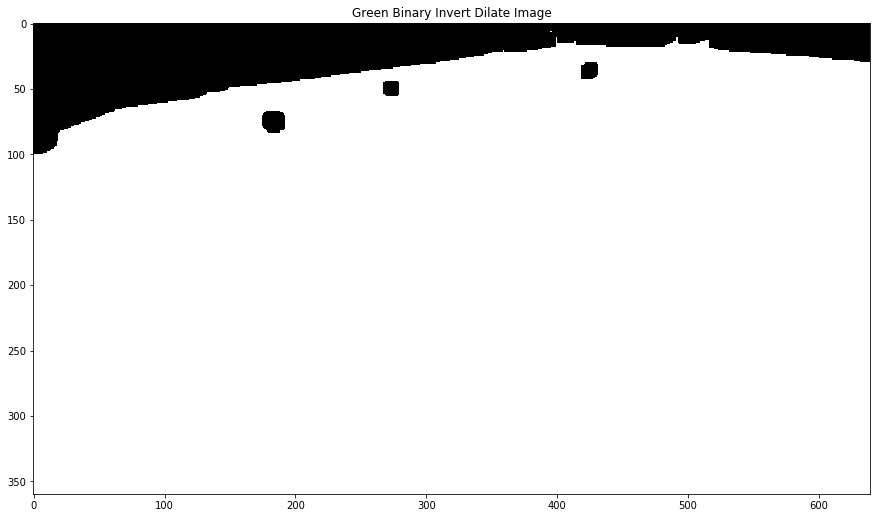

In [17]:
kernel = np.ones((5,5),np.uint8)
dnsize = 2
gBinaryInvertDilate = cv2.dilate(gBinaryInvertErode,kernel,iterations = dnsize)
plt.imshow(gBinaryInvertDilate, cmap='Greys')
plt.title('Green Binary Invert Dilate Image')
plt.show()

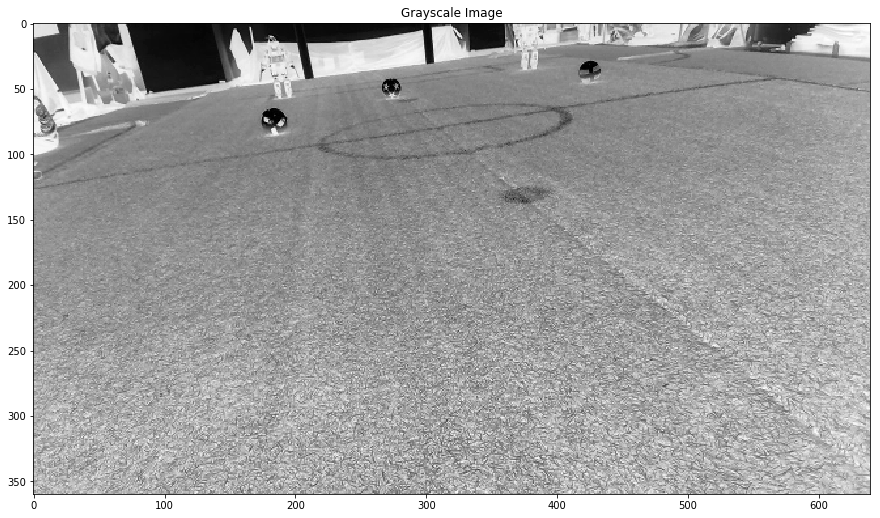

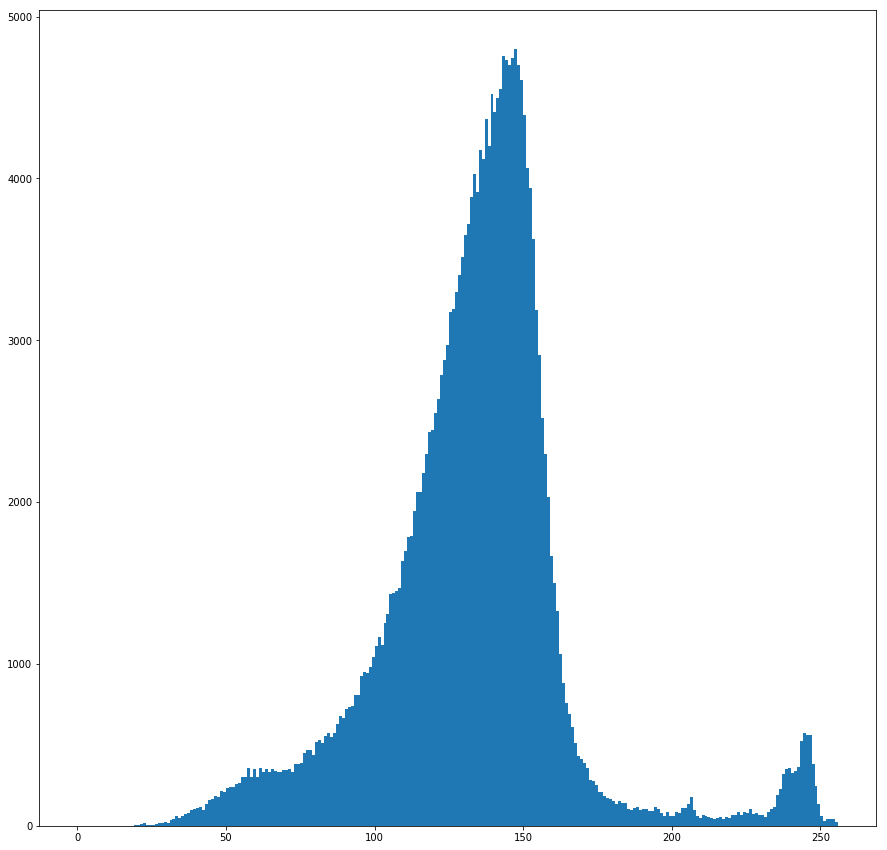

In [23]:
grayscaleImage = cv2.cvtColor(rgbImage, cv2.COLOR_BGR2GRAY)

plt.imshow(grayscaleImage, cmap="Greys")
plt.title('Grayscale Image')
plt.show()

plt.hist(grayscaleImage.ravel(),256,[0,256])
plt.show()

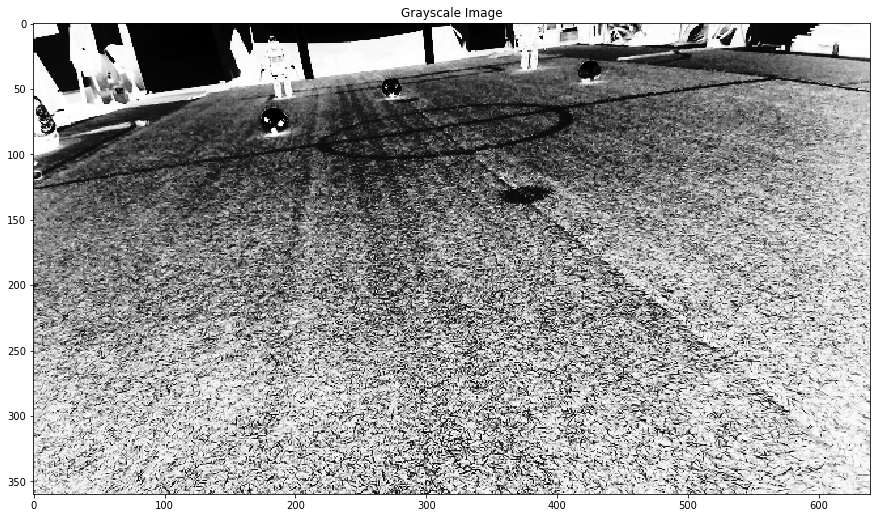

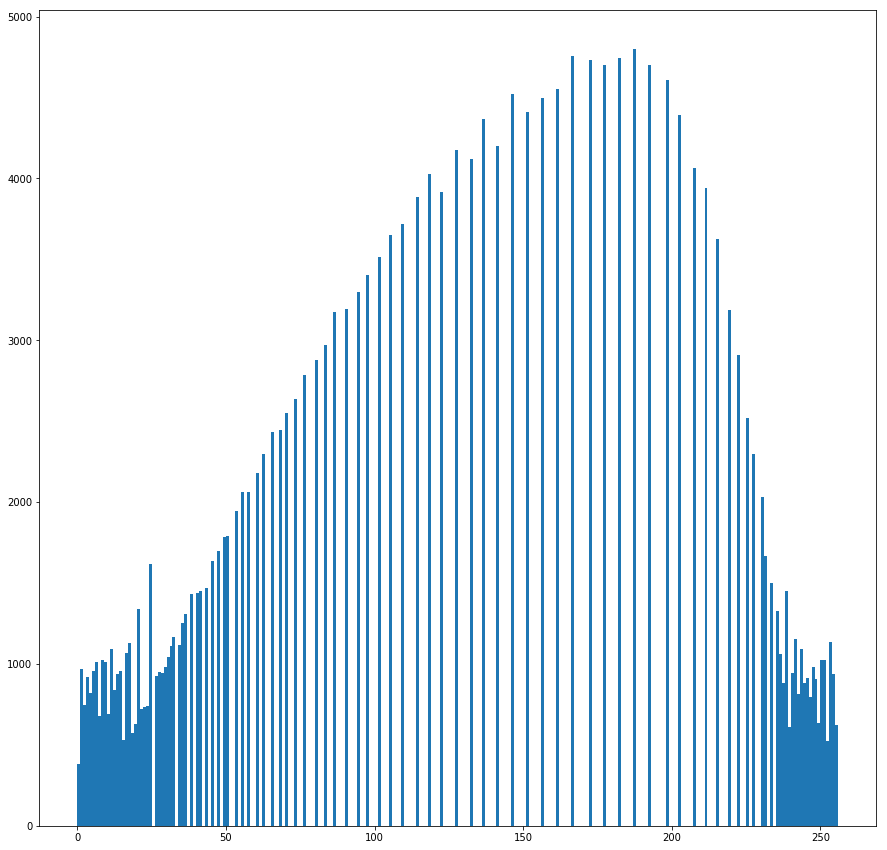

In [24]:
equ = cv2.equalizeHist(grayscaleImage)
res = np.hstack((grayscaleImage,equ)) #stacking images side-by-side
plt.imshow(equ, cmap="Greys")
plt.title('Grayscale Image')
plt.show()

plt.hist(equ.ravel(),256,[0,256])
plt.show()

Deteksi contour dari warna hijau yang di-invert. Hasil fungsi **cv2.findContours** berupa sebuah list contour. List contour tersebut di-*sorting* berdasarkan ukuran yang terbesar dan diambil lima yang terbesar. 

In [19]:
# Representasi rectangle dari opencv berupa point top left, width, dan height
# Fungsi ini merubah ke dalam representasi rectangle ke dalam bentuk array empat buah titik
def rectToPoints(rectTopLeftX, rectTopLeftY, rectWidth, rectHeight):
    npPtRect = np.zeros((4,2), dtype=int)
    # top left     
    npPtRect[0,0] = rectTopLeftX
    npPtRect[0,1] = rectTopLeftY
    # top right     
    npPtRect[1,0] = rectTopLeftX + rectWidth
    npPtRect[1,1] = rectTopLeftY
    # bottom left     
    npPtRect[2,0] = rectTopLeftX 
    npPtRect[2,1] = rectTopLeftY + rectHeight
    # bottom right     
    npPtRect[2,0] = rectTopLeftX + rectWidth
    npPtRect[2,1] = rectTopLeftY + rectHeight
    
    return npPtRect
    

Contour properties : 1.05882352941 0.789215686275 0.98773006135


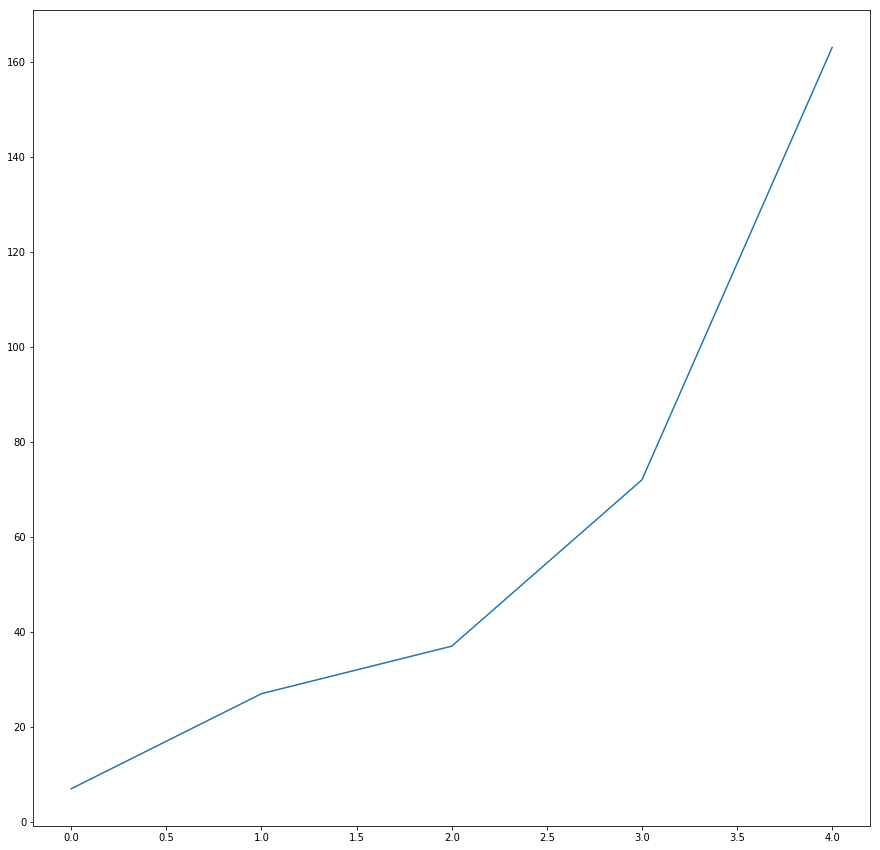

Contour properties : 1.0 0.792899408284 0.988929889299


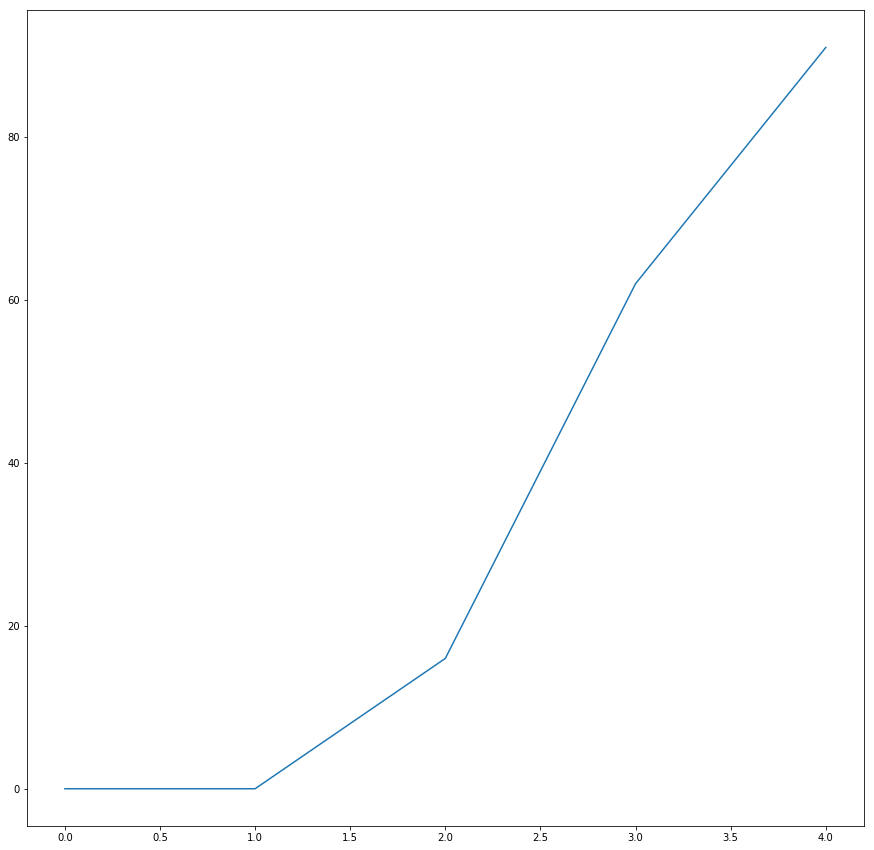

Contour properties : 1.0 0.815972222222 1.0


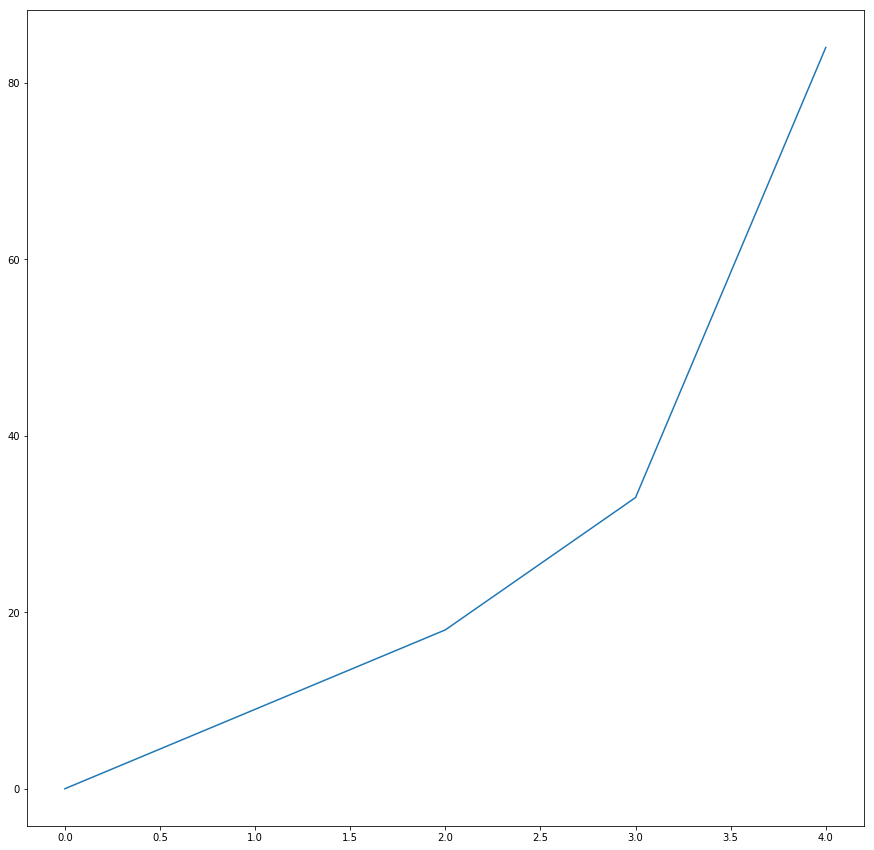

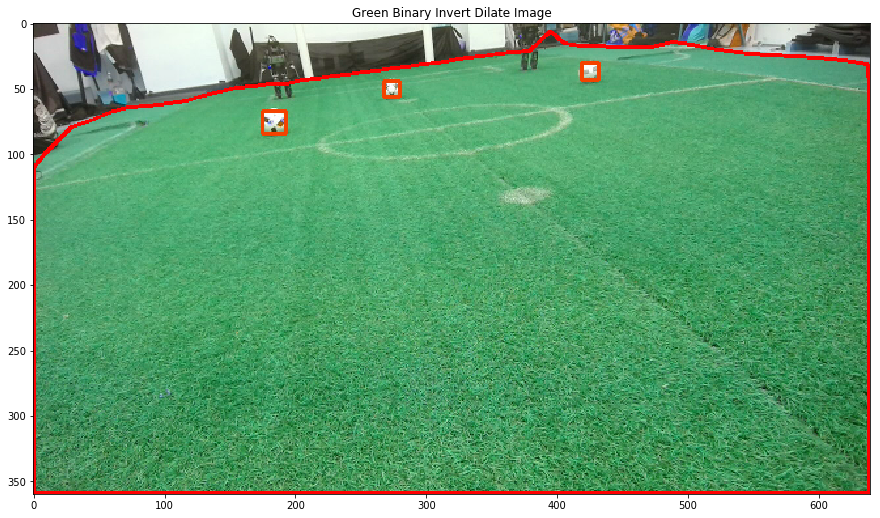

In [20]:
_, listBallContours, hierarchy = cv2.findContours(gBinaryInvertDilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(listBallContours) > 0:
    listSortedBallContours = sorted(listBallContours, key=cv2.contourArea, reverse=True)[:10]
    for ballContour in listSortedBallContours:
        ballTopLeftX, ballTopLeftY, ballWidth, ballHeight = cv2.boundingRect(ballContour)
        rectPoint = rectToPoints(ballTopLeftX, ballTopLeftY, ballWidth, ballHeight)
        insideField = False
        insideFieldContour = 0
        for point in rectPoint:
            resultTest = cv2.pointPolygonTest(fieldContour,(rectPoint[0][0],rectPoint[0][1]),False)
            if resultTest == 1:
                insideFieldContour += 1
        # Jika semua titik di dalam contour lapangan
        if insideFieldContour == 4:
            insideFieldContour = 0
            # Machine learning parameter
            # Aspect Ratio is the ratio of width to height of bounding rect of the object.
            ballAspectRatio = float(ballWidth)/ballHeight
            # Extent is the ratio of contour area to bounding rectangle area.
            ballArea = cv2.contourArea(ballContour)
            ballRectArea = ballWidth*ballHeight
            ballExtent = float(ballArea)/ballRectArea
            # Solidity is the ratio of contour area to its convex hull area.
            ballHull = cv2.convexHull(ballContour)
            ballHullArea = cv2.contourArea(ballHull)
            ballSolidity = float(ballArea)/ballHullArea
            # Print contour properties
            print 'Contour properties : {} {} {}'.format(ballAspectRatio, ballExtent, ballSolidity)
            
            ballRoi = grayscaleImage[ballTopLeftY:ballTopLeftY + ballHeight, ballTopLeftX:ballTopLeftX + ballWidth]

            ballHistogram = cv2.calcHist([ballRoi],[0],None,[5],[0,256])
            plt.plot(ballHistogram)
            plt.show()

            ballColor = (244, 66, 0)
            cv2.rectangle(modRgbImage, (ballTopLeftX,ballTopLeftY), (ballTopLeftX + ballWidth, ballTopLeftY + ballHeight), ballColor, 2)

            if ballHistogram[2] > 800:
                ballColor = (244, 66, 66)
                # Gambar kotak
                cv2.rectangle(modRgbImage, (ballTopLeftX,ballTopLeftY), (ballTopLeftX + ballWidth, ballTopLeftY + ballHeight), ballColor, 2)
        
plt.imshow(modRgbImage)
plt.title('Green Binary Invert Dilate Image')
plt.show()

# Create contour dari scan rotate
# cek keempat point apakah berada dalam contour


## Convert to Grayscale

### Mode 2

In [ ]:
# Setting HSV White
wHMin = wg.IntSlider(value=0,   min=0, max= 255, description='Wh H Min : ')
wSMin = wg.IntSlider(value=0,   min=0, max= 255, description='Wh S Min : ')
wVMin = wg.IntSlider(value=140, min=0, max= 255, description='Wh V Min : ')

wHMax = wg.IntSlider(value=255, min=0, max= 255, description='Wh H Max : ')
wSMax = wg.IntSlider(value=255, min=0, max= 255, description='Wh S Max : ')
wVMax = wg.IntSlider(value=255, min=0, max= 255, description='Wh V Max : ')

display(wHMin, wSMin, wVMin, wHMax, wSMax, wVMax)

In [ ]:
lowerWhite = np.array([wHMin.value,wSMin.value,wVMin.value])
upperWhite = np.array([wHMax.value,wSMax.value,wVMax.value])
wBinary = cv2.inRange(hsvImage, lowerWhite, upperWhite)
plt.imshow(wBinary, cmap=plt.cm.binary)
plt.title('White Binary Image')
plt.show()